In [29]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import io
import base64
from IPython.display import Image

In [2]:
np.random.seed(42)

In [3]:
def generate_modulation_data(n_samples=1200, signal_length=1024):
    """
    Генерация данных различных типов модуляции с использованием
    математического аппарата модуляции сигналов
    Parameters:
    n_samples (int): общее количество образцов
    signal_length (int): длина каждого сигнала в отсчетах
    Returns:
    tuple: массив признаков X и массив меток y
    """
    np.random.seed(42)
    data = []
    labels = []
    samples_per_class = n_samples // 4
    # Параметры сигналов
    fs = 1000.0  # Частота дискретизации (Гц)
    fc = 100.0  # Несущая частота (Гц)
    fm = 10.0  # Частота модуляции (Гц)
    t = np.linspace(0, signal_length / fs, signal_length, endpoint=False)
    print(f"Генерация {n_samples} образцов сигналов...")
    print(f"Параметры: fs={fs} Гц, fc={fc} Гц, длина={signal_length} отсчетов")
    for i in range(n_samples):
        # Случайные параметры для каждого сигнала
        snr_db = np.random.uniform(5, 25)  # SNR от 5 до 25 дБ
        noise_power = 10 ** (-snr_db / 10)
        # Определяем тип модуляции
        mod_type = i // samples_per_class
        if mod_type == 0:  # AM (Amplitude Modulation)
            # Параметры AM
            ka = np.random.uniform(0.3, 0.9)  # Коэффициент модуляции
            phase_offset = np.random.uniform(0, 2 * np.pi)
            # Модулирующий сигнал (случайная комбинация синусоид)
            m_t = np.random.uniform(0.5, 1.5) * np.sin(2 * np.pi * fm * t + np.random.uniform(0, 2 * np.pi))
            if np.random.random() > 0.5:
                m_t += 0.3 * np.random.uniform(0.5, 1.5) * np.sin(2 * np.pi * 2 * fm * t + np.random.uniform(0, 2 * np.pi))
            # AM сигнал: s(t) = [1 + ka*m(t)] * cos(2πfc*t + φ)
            carrier = np.cos(2 * np.pi * fc * t + phase_offset)
            signal = (1 + ka * m_t) * carrier
            labels.append('AM')

        elif mod_type == 1:  # FM (Frequency Modulation)
            # Параметры FM
            kf = np.random.uniform(20, 50)  # Девиация частоты
            phase_offset = np.random.uniform(0, 2 * np.pi)
            amplitude = np.random.uniform(0.8, 1.2)
            phase_offset = np.random.uniform(0, 2 * np.pi)
            # Модулирующий сигнал
            m_t = np.random.uniform(0.5, 1.5) * np.sin(2 * np.pi * fm * t + np.random.uniform(0, 2 * np.pi))
            if np.random.random() > 0.5:
                m_t += 0.4 * np.random.uniform(0.5, 1.5) * np.cos(2 * np.pi * 1.5 * fm * t + np.random.uniform(0, 2 * np.pi))
            # FM сигнал: s(t) = A * cos(2πfc*t + kf∫m(τ)dτ + φ)
            # Интеграл аппроксимируем кумулятивной суммой
            dt = t[1] - t[0]
            integral_m = np.cumsum(m_t) * dt
            signal = amplitude * np.cos(2 * np.pi * fc * t + kf * integral_m + phase_offset)
            labels.append('FM')

        elif mod_type == 2:  # PSK (Phase Shift Keying)
            # Параметры BPSK/QPSK
            amplitude = np.random.uniform(0.9, 1.1)
            symbol_rate = np.random.uniform(5, 15)  # Символьная скорость
            samples_per_symbol = int(fs / symbol_rate)
            # Генерация случайной битовой последовательности
            num_symbols = signal_length // samples_per_symbol
            if np.random.random() > 0.5:  # BPSK
                phases = np.random.choice([0, np.pi], num_symbols)
            else:  # QPSK
                phases = np.random.choice([0, np.pi / 2, np.pi, 3 * np.pi / 2], num_symbols)

            # Формирование PSK сигнала
            signal = np.zeros(signal_length)
            for j in range(num_symbols):
                start_idx = j * samples_per_symbol
                end_idx = min((j + 1) * samples_per_symbol, signal_length)
                t_symbol = t[start_idx:end_idx]
                signal[start_idx:end_idx] = amplitude * np.cos(2 * np.pi * fc * t_symbol + phases[j])
            labels.append('PSK')

        else: # QAM (Quadrature Amplitude Modulation)
            # Параметры QAM
            symbol_rate = np.random.uniform(5, 15)
            samples_per_symbol = int(fs / symbol_rate)
            num_symbols = signal_length // samples_per_symbol
            # Случайный выбор между 16-QAM и 64-QAM
            if np.random.random() > 0.5:  # 16-QAM
                constellation = [-3, -1, 1, 3]
            else:  # 64-QAM (упрощенная)
                constellation = [-7,-5,-3,-1, 1, 3, 5, 7]

            # Генерация символов I и Q
            I_symbols = np.random.choice(constellation, num_symbols)
            Q_symbols = np.random.choice(constellation, num_symbols)
            # Нормировка амплитуды
            norm_factor = np.random.uniform(0.1, 0.3)
            I_symbols = I_symbols * norm_factor
            Q_symbols = Q_symbols * norm_factor

            # Формирование QAM сигнала: s(t) = I(t)*cos(2πfc*t) - Q(t)*sin(2πfc*t)
            signal = np.zeros(signal_length)
            for j in range(num_symbols):
                start_idx = j * samples_per_symbol
                end_idx = min((j + 1) * samples_per_symbol, signal_length)
                t_symbol = t[start_idx:end_idx]
                I_component = I_symbols[j] * np.cos(2 * np.pi * fc * t_symbol)
                Q_component = Q_symbols[j] * np.sin(2 * np.pi * fc * t_symbol)
                signal[start_idx:end_idx] = I_component - Q_component
            labels.append('QAM')

        # Добавление AWGN шума
        noise = np.sqrt(noise_power) * np.random.randn(signal_length)
        noisy_signal = signal + noise
        # Вычисление признаков из сигнала
        features = extract_signal_features(noisy_signal, fs, fc)
        data.append(features)
        if (i + 1) % (n_samples // 10) == 0:
            print(f"Сгенерировано {i + 1}/{n_samples} сигналов...")

    print("Генерация завершена!")
    return np.array(data), np.array(labels)

def extract_signal_features(signal, fs, fc):
    """
    Извлечение признаков из модулированного сигнала
    Parameters:
    signal (array): временной сигнал
    fs (float): частота дискретизации
    fc (float): несущая частота
    Returns:
    list: список признаков [amplitude_var, frequency_var, phase_var, snr]

    """
    # 1. Вычисление мгновенной амплитуды через аналитический сигнал
    analytic_signal = signal + 1j * np.imag(np.fft.ifft(np.fft.fft(signal) * np.where(
        np.arange(len(signal)) <= len(signal)//2, 2, 0)))
    instantaneous_amplitude = np.abs(analytic_signal)

    # 2. Вычисление мгновенной частоты
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Удаление выбросов в частоте
    freq_median = np.median(instantaneous_frequency)
    freq_mask = np.abs(instantaneous_frequency - freq_median) < 3 * np.std(instantaneous_frequency)
    if np.sum(freq_mask) > len(instantaneous_frequency) // 2:
        instantaneous_frequency = instantaneous_frequency[freq_mask]

    # 3. Вычисление мгновенной фазы (относительно несущей)
    t = np.arange(len(signal)) / fs
    reference_phase = 2 * np.pi * fc * t
    phase_deviation = np.unwrap(instantaneous_phase - reference_phase)
    # 4. Вариации параметров
    amplitude_var = np.var(instantaneous_amplitude)
    frequency_var = np.var(instantaneous_frequency) if len(instantaneous_frequency) > 1 else 0
    phase_var = np.var(np.diff(phase_deviation)) if len(phase_deviation) > 1 else 0
    # 5. Оценка SNR через отношение мощностей
    signal_power = np.mean(signal ** 2)
    # Оценка шума через высокочастотные компоненты
    noise_estimate = np.std(np.diff(signal)) / np.sqrt(2)
    noise_power = noise_estimate ** 2
    snr_linear = signal_power / (noise_power + 1e-10)
    snr_db = 10 * np.log10(snr_linear + 1e-10)
    # Нормализация признаков для лучшей сходимости
    amplitude_var = np.clip(amplitude_var, 0, 2.0)
    frequency_var = np.clip(frequency_var / 1000.0, 0, 2.0)  # Нормализация
    phase_var = np.clip(phase_var, 0, 2.0)
    snr_db = np.clip(snr_db, 0, 30)
    return [amplitude_var, frequency_var, phase_var, snr_db]

In [4]:
# Генерация данных
X, y = generate_modulation_data(1200)

Генерация 1200 образцов сигналов...
Параметры: fs=1000.0 Гц, fc=100.0 Гц, длина=1024 отсчетов
Сгенерировано 120/1200 сигналов...
Сгенерировано 240/1200 сигналов...
Сгенерировано 360/1200 сигналов...
Сгенерировано 480/1200 сигналов...
Сгенерировано 600/1200 сигналов...
Сгенерировано 720/1200 сигналов...
Сгенерировано 840/1200 сигналов...
Сгенерировано 960/1200 сигналов...
Сгенерировано 1080/1200 сигналов...
Сгенерировано 1200/1200 сигналов...
Генерация завершена!


In [5]:
# Создание DataFrame для удобства
df = pd.DataFrame(X, columns=['Amplitude_Var', 'Frequency_Var', 'Phase_Var', 'SNR'])
df['Modulation_Type'] = y
# Анализ данных
print("Размер датасета:", df.shape)
print("\nРаспределение классов:")
print(df['Modulation_Type'].value_counts())

Размер датасета: (1200, 5)

Распределение классов:
Modulation_Type
AM     300
FM     300
PSK    300
QAM    300
Name: count, dtype: int64


In [25]:
print(df.describe())

       Amplitude_Var  Frequency_Var    Phase_Var          SNR
count    1200.000000    1200.000000  1200.000000  1200.000000
mean        0.141666       1.411649     0.252203     5.645174
std         0.129581       0.699918     0.250282     1.331886
min         0.003500       0.100339     0.004831     0.205437
25%         0.044983       0.710184     0.060741     4.759691
50%         0.098107       1.982045     0.166434     6.082674
75%         0.205729       2.000000     0.373226     6.762786
max         0.761841       2.000000     1.507740     7.104263


In [7]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Инициализация моделей
models = {
'k-NN': KNeighborsClassifier(n_neighbors=5),
'Decision Tree': DecisionTreeClassifier(random_state=42),
'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [28]:
# Обучение и оценка моделей
results = {}
for name, model in models.items():
    # Обучение
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    # Прогноз
    y_pred = model.predict(X_test)
    # Оценка точности
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"\n{name}:")
    print(f"Точность: {accuracy:.3f}")
    print(f"Время обучения: {fit_time:.3f} сек")
    print("Отчет по классификации:")
    print(classification_report(y_test, y_pred))


k-NN:
Точность: 0.644
Время обучения: 0.008 сек
Отчет по классификации:
              precision    recall  f1-score   support

          AM       0.69      0.77      0.72        94
          FM       0.66      0.91      0.77        91
         PSK       0.61      0.46      0.52        92
         QAM       0.57      0.42      0.49        83

    accuracy                           0.64       360
   macro avg       0.63      0.64      0.62       360
weighted avg       0.63      0.64      0.63       360


Decision Tree:
Точность: 0.731
Время обучения: 0.003 сек
Отчет по классификации:
              precision    recall  f1-score   support

          AM       0.74      0.81      0.77        94
          FM       0.80      0.77      0.79        91
         PSK       0.72      0.73      0.72        92
         QAM       0.65      0.60      0.62        83

    accuracy                           0.73       360
   macro avg       0.73      0.73      0.73       360
weighted avg       0.73      0

Скопируйте эту строку в ваш MD файл:


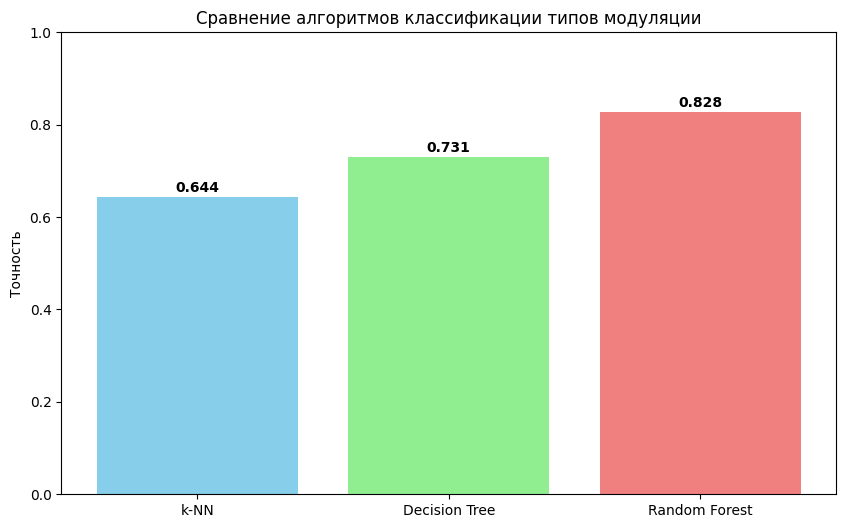

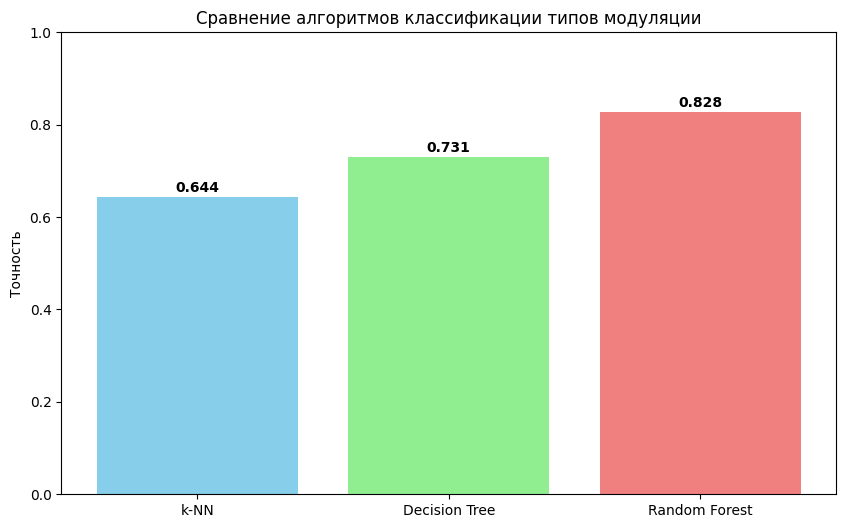

In [30]:
# График сравнения алгоритмов
plt.figure(figsize=(10, 6))
algorithms = list(results.keys())
accuracies = list(results.values())
plt.bar(algorithms, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Точность')
plt.title('Сравнение алгоритмов классификации типов модуляции')
plt.ylim([0, 1])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Сохраняем в buffer
buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
buf.seek(0)

# Конвертируем в base64
image_base64 = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

# Создаем MD строку
md_image = f"![Описание графика](data:image/png;base64,{image_base64})"

# Выводим для копирования
print("Скопируйте эту строку в ваш MD файл:")
print(md_image)

plt.show()

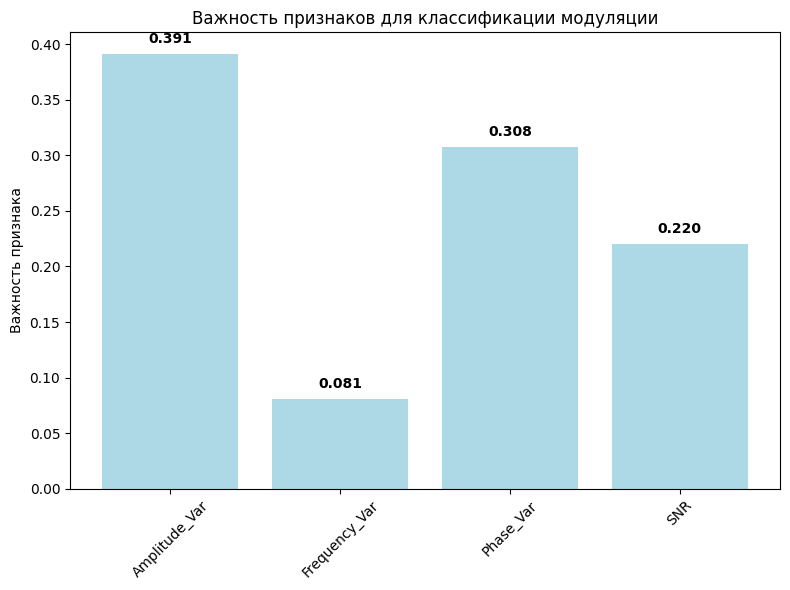

In [11]:
# Анализ важности признаков (для Random Forest)
rf_model = models['Random Forest']
feature_names = ['Amplitude_Var', 'Frequency_Var', 'Phase_Var', 'SNR']
importances = rf_model.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(feature_names, importances, color='lightblue')
plt.ylabel('Важность признака')
plt.title('Важность признаков для классификации модуляции')


plt.xticks(rotation=45)
for i, v in enumerate(importances):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.svm import SVC

In [13]:
svm_models = {
    'linear': SVC(kernel='linear'),
    'poly': SVC(kernel='poly'),
    'rbf': SVC(kernel='rbf')
}

In [14]:
# Обучение и оценка моделей
results = {}
for name, model in svm_models.items():
    # Обучение
    model.fit(X_train, y_train)
    # Прогноз
    y_pred = model.predict(X_test)
    # Оценка точности
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"\n{name}:")
    print(f"Точность: {accuracy:.3f}")
    print("Отчет по классификации:")
    print(classification_report(y_test, y_pred))


linear:
Точность: 0.636
Отчет по классификации:
              precision    recall  f1-score   support

          AM       0.68      0.76      0.72        94
          FM       0.59      0.93      0.72        91
         PSK       0.67      0.47      0.55        92
         QAM       0.64      0.36      0.46        83

    accuracy                           0.64       360
   macro avg       0.64      0.63      0.61       360
weighted avg       0.65      0.64      0.62       360


poly:
Точность: 0.456
Отчет по классификации:
              precision    recall  f1-score   support

          AM       0.67      0.37      0.48        94
          FM       0.50      0.53      0.51        91
         PSK       0.45      0.43      0.44        92
         QAM       0.33      0.49      0.40        83

    accuracy                           0.46       360
   macro avg       0.49      0.46      0.46       360
weighted avg       0.49      0.46      0.46       360


rbf:
Точность: 0.381
Отчет по кла

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# Задаем сетку параметров, которые хотим перебрать
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],      # Попробуем эти значения для C
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # И эти для gamma
}

In [17]:
# Создаем модель SVM с RBF-ядром
svc_rbf = SVC(kernel='rbf')

In [18]:
# Создаем объект GridSearchCV
grid_search = GridSearchCV(
    estimator=svc_rbf,
    param_grid=param_grid,
    cv=5,           # 5-кратная кросс-валидация
    scoring='accuracy', # Критерий для выбора лучшей модели (точность)
    n_jobs=-1       # Использовать все ядра процессора
)

# Запускаем подбор параметров (это может занять время)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             scoring='accuracy')

In [19]:
best_svm_rbf = grid_search.best_estimator_

best_svm_rbf.fit(X_train, y_train)
# Прогноз
y_pred = best_svm_rbf.predict(X_test)
# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность: {accuracy:.3f}")
print("Отчет по классификации:")
print(classification_report(y_test, y_pred))

Точность: 0.836
Отчет по классификации:
              precision    recall  f1-score   support

          AM       0.79      0.99      0.88        94
          FM       0.93      0.92      0.93        91
         PSK       0.81      0.80      0.81        92
         QAM       0.81      0.60      0.69        83

    accuracy                           0.84       360
   macro avg       0.84      0.83      0.83       360
weighted avg       0.84      0.84      0.83       360

